# Initial EDA and Cleaning
-----------

In [1]:
# Import general libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

----------

### Useful Functions

In [2]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller_test(data, alpha):
    is_stationary = adfuller(data)[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(adfuller(data)[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(adfuller(data)[1],3)}')
    return

In [3]:
# Defining a function to pop things from a list.
def without(lst, idx):
    return [x for i, x in enumerate(lst) if i != idx]

In [4]:
# Creating function to melt dataframes and set time-date index
#      - To use this function your dataframe must be in wide format with your first column as your intended columns.
#      - IE, your dataframe should look like this:
#       =====================================================
#       =      = Cities = 1996-01 = 1996-02 = 1996-03 = ... = 
#       =====================================================
#       =      = Dallas = 334200. = 123456. = 123525. = ... =
#       =      = Austin = 235700. = 123456. = 123552. = ... =
#       =      = San A* = 500900. = 123456. = 123235. = ... =
#       =      = Porch  = 1287700 = 1234567 = 123123. = ... =
#       = ...  =
#       =      = Katy   = 235700. = 12345.0 = 1231.01 = ... =
#       =      = McKin* = 235700. = 123445. = 123456. = ... =
#       =      = El Pa* = 1287700 = 1234565 = 1234512 = ... =
#       =====================================================

def format_df(df):
    test_list = pd.melt(df, id_vars = df.columns.to_list()[:1], var_name='Date')
    test_list['Date'] = pd.to_datetime(test_list['Date'], infer_datetime_format=True)
    test_list = test_list.dropna(subset=['value'])
    test_list.groupby('Date').aggregate({'value':'mean'})
    return test_list.pivot_table(index='Date', columns=df.columns.to_list()[:1], values='value')


In [5]:
# This function takes a formatted dataframe from format_df(), a window for the rolling mean 
# and an alpha for a dicky fuller test and performs two transformations:
#
# 1. The dataframe's rolling average is subtracted from the dataframe and a fuller score is printed.
#
# 2. A difference is performed on the dataframe resulting from step 1 and a fuller score is printed.
#
# The function returns the transformed dataframe. If the steps prior are sufficient to make a stationary
# series, the function will return the dataframe that is sufficiently stationary.

def stationizer(df, window, alpha=0.05, verbose=True):
    df1 = df - df.rolling(window=window).mean().dropna()
    df2 = df1.diff().dropna()
    df3 = df.diff().dropna()
    df4 = df.diff().diff().dropna()
    
    if verbose == True:
        print(f'Before transformations:')
        dicky_fuller_test(df.dropna(), alpha)
        print(f'After subtracting rolling mean:')
        dicky_fuller_test(df1.dropna(), alpha)
        print(f'After differencing:')
        dicky_fuller_test(df2.dropna(), alpha)
        print('With only differencing:')
        dicky_fuller_test(df3.dropna(), alpha)
        print('With differencing twice:')
        dicky_fuller_test(df4.dropna(), alpha)
    
    if adfuller(df)[1] < alpha:
        return df
    elif adfuller(df1.dropna())[1] < alpha:
        return df1
    elif adfuller(df3.dropna())[1] < alpha:
        return df3
    elif adfuller(df2.dropna())[1] < alpha:
        return df2
    else:
        return df4

In [6]:
# This function returns the dataframe with quartarly ROI values for a given set of price in series.

def get_qroi(d):
    return (d.rolling(window = 3).max() - d.rolling(window = 3).min()) / d.rolling(window = 3).min()

In [7]:
# This function checks for null values by column
def get_na(df):
    for i in df.columns:
        if df[i].isna().value_counts().tolist()[0] != df.shape[0]:
            print(f'{i} has null values')
    pass

In [8]:
def fix_na(df):
    # interpolate and backfill
    df = df.interpolate(method='linear').fillna(value=None, method='backfill', axis=None, limit=None, downcast=None).dropna(axis=1, how='all')
    return df

----------

## Viewing RAW

In [9]:
# Load in the dataset
raw = pd.read_csv("./00_Source_Data/zillow_data.csv")
raw.shape

(14723, 272)

In [10]:
raw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


--------------

## Reformating RAW

In [11]:
# We're interested in value by zipcode, so lets drop all the other location identifiers

# First, lets make a dictionary to reference the zipcode to a place
unique_zipcodes = raw["RegionName"].unique()
unique_cities = raw['City'].unique()
unique_metros = raw['Metro'].unique()
unique_counties = raw['CountyName'].unique()
unique_states = raw['State'].unique()

# Print out the length of the unique vars
print(f'There are {len(unique_zipcodes)} unique zipcodes.')
print(f'There are {len(unique_cities)} unique cities.')
print(f'There are {len(unique_metros)} unique metros.')
print(f'There are {len(unique_counties)} unique counties.')
print(f'There are {len(unique_states)} unique states.')
      

There are 14723 unique zipcodes.
There are 7554 unique cities.
There are 702 unique metros.
There are 1212 unique counties.
There are 51 unique states.


In [12]:
# Making different dataframes to group by different sets for exploration

# Collecting columns with locators
locators = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

# Creating seperate dataframes by locators
df_zips = raw.drop(columns= without(locators, 1))
df_cities = raw.drop(columns= without(locators, 2))
df_states = raw.drop(columns= without(locators, 3))
df_metros = raw.drop(columns= without(locators, 4))
df_counties = raw.drop(columns= without(locators, 5))

In [14]:
# Creating a list of dataframes we're interested in looking at for iterating processes.
datalist = [df_states, df_metros, df_counties, df_cities]

for i, s in enumerate(datalist):
    datalist[i] = format_df(s)

--------------------

## Exploratory Analysis

Zipcodes are not useful to group by because the dataset itself is already grouped by zipcodes. Therefore `df_zip` is the same as `raw` without other locator columns and will be omitted from the grouping process.

Likewise, `df_states` will be grouped, but it will inevitably generalize over large areas and may not be as useful as other locators. It's important to note that there will be disparity between the number of records in the states and thus an average of records in one state with a large area will likely have a larger volume to be averaged than a state with less area. This could result in bias for either small or large states.

In [15]:
t = datalist[0]
t

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-01,128382.142857,86795.569620,68868.041237,116202.790698,200220.959596,142561.943320,157189.516129,189216.666667,125784.615385,104529.019608,...,54320.000000,66087.468672,109384.639831,159645.689655,122071.236559,82825.00,140589.285714,115151.376147,66461.666667,138712.500000
1996-05-01,128832.142857,87122.151899,69015.463918,116562.790698,200124.831650,142765.991903,157063.709677,188611.111111,126234.615385,104594.117647,...,54640.000000,66340.852130,109406.885593,159523.275862,122136.827957,82556.25,140838.988095,115099.388379,66575.000000,138762.500000
1996-06-01,129253.571429,87460.759494,69140.206186,116934.883721,200035.942761,142985.425101,156926.612903,188011.111111,126665.384615,104662.352941,...,54960.000000,66594.987469,109451.377119,159406.896552,122201.075269,82306.25,141101.488095,115032.110092,66708.333333,138741.666667
1996-07-01,129639.285714,87798.734177,69262.886598,117315.348837,199965.572391,143204.453441,156778.225806,187438.888889,127026.923077,104727.058824,...,55290.000000,66843.107769,109521.504237,159313.793103,122267.204301,82037.50,141378.571429,114940.672783,66848.333333,138641.666667
1996-08-01,130028.571429,88156.962025,69378.350515,117719.534884,199958.754209,143461.943320,156640.322581,186900.000000,127346.153846,104816.993464,...,55660.000000,67081.704261,109613.983051,159254.310345,122352.419355,81781.25,141686.011905,114840.978593,67016.666667,138533.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,322657.142857,151629.508197,133188.571429,265908.260870,723263.480392,396777.510040,282175.806452,790450.000000,274487.804878,280250.955414,...,188426.315789,146519.306931,193761.274014,307212.396694,280219.700748,216318.75,394339.589443,195418.072289,124022.222222,227525.806452
2018-01-01,323775.000000,152402.732240,133522.857143,267327.826087,729496.405229,399905.220884,282852.419355,793622.222222,277912.195122,281561.401274,...,189621.052632,147265.841584,194417.492417,309129.752066,280900.997506,214750.00,398688.563050,196397.891566,124104.166667,228564.516129
2018-02-01,324167.857143,153625.683060,134456.190476,268714.782609,735525.980392,403134.939759,283826.612903,798838.888889,279470.731707,283416.178344,...,191110.526316,148351.980198,195503.134479,311445.454545,282143.640898,213581.25,402129.912023,197306.024096,124334.722222,229938.709677


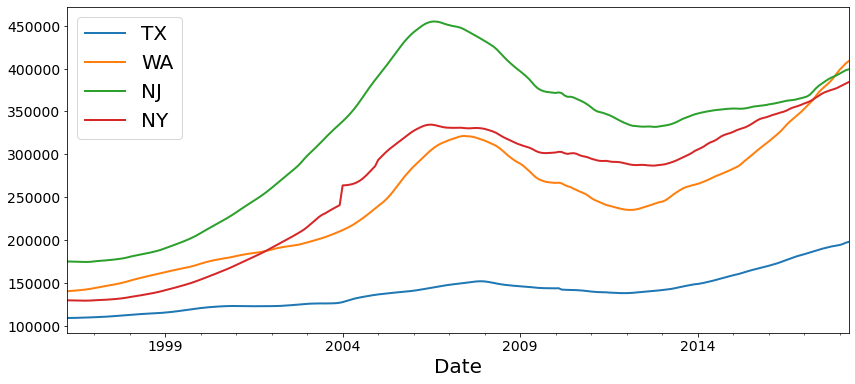

In [16]:
t['TX'].plot(figsize=(14,6), linewidth=2, fontsize=14)
t['WA'].plot(figsize=(14,6), linewidth=2, fontsize=14)
t['NJ'].plot(figsize=(14,6), linewidth=2, fontsize=14)
t['NY'].plot(figsize=(14,6), linewidth=2, fontsize=14)
plt.legend(fontsize=20)
plt.xlabel('Date',fontsize=20);

In [17]:
tx_diff = t['TX'].diff().dropna()

<AxesSubplot:xlabel='Date'>

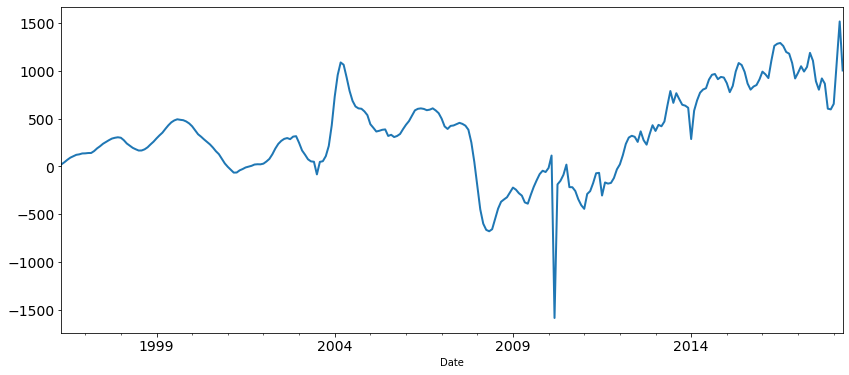

In [18]:
tx_diff.plot(figsize=(14,6), linewidth=2, fontsize=14)

In [19]:
dicky_fuller_test(tx_diff, 0.05)

The data is not stationary with a fuller score of 0.28


In [20]:
tx_roll = t['TX'].rolling(window=12).mean().dropna()
tx_norm = t['TX'] - tx_roll

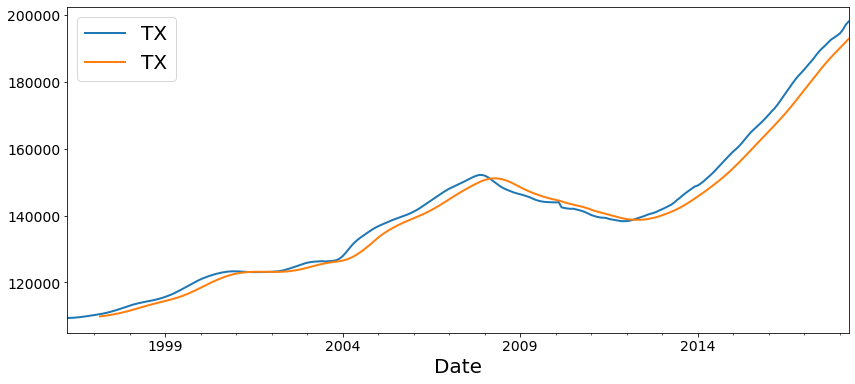

In [21]:
t['TX'].plot(figsize=(14,6), linewidth=2, fontsize=14)
tx_roll.plot(figsize=(14,6), linewidth=2, fontsize=14)
plt.legend(fontsize=20)
plt.xlabel('Date',fontsize=20);

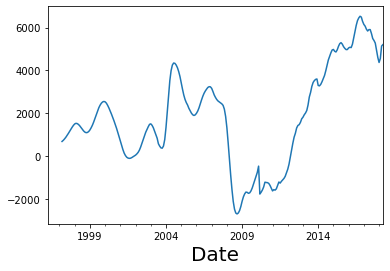

In [22]:
tx_norm.plot()
plt.xlabel('Date',fontsize=20);

In [23]:
dicky_fuller_test(tx_norm.diff().dropna(), 0.05)

The data is stationary with a fuller score of 0.0


In [24]:
tx_flat = tx_norm.diff().dropna()

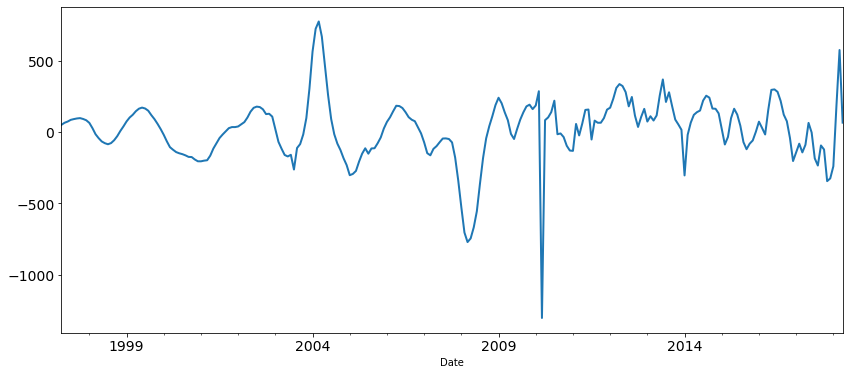

In [25]:
tx_flat.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [26]:
az_flat = stationizer(t['AZ'], 12)

Before transformations:
The data is not stationary with a fuller score of 0.183
After subtracting rolling mean:
The data is not stationary with a fuller score of 0.082
After differencing:
The data is stationary with a fuller score of 0.001
With only differencing:
The data is not stationary with a fuller score of 0.127
With differencing twice:
The data is stationary with a fuller score of 0.0


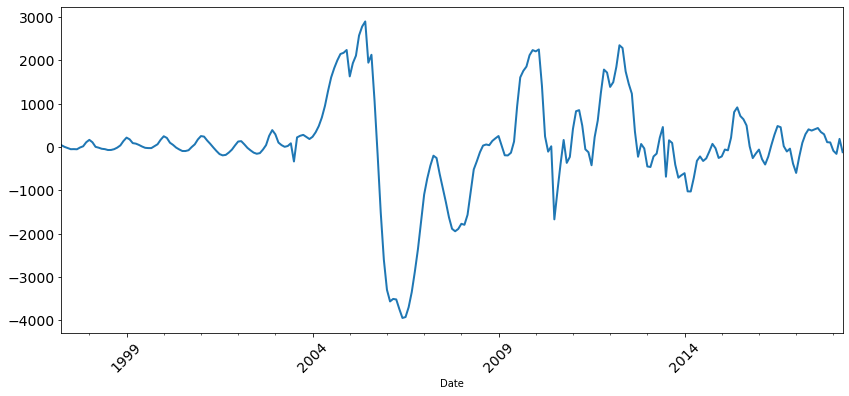

In [39]:
az_flat.plot(figsize=(14,6), linewidth=2, fontsize=14, rot=45);


# Feature Engineering

We need to convert our price data into quartarly ROI using a rolling ROI function before making items stationary.

In [28]:
# dummy data set for engineering
d = datalist[0]

d_roi = (d.rolling(window = 3).max() - d.rolling(window = 3).min()) / d.rolling(window = 3).min()

In [29]:
d_roi.tail()

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,0.007719,0.007253,0.001619,0.011503,0.017942,0.013328,0.003695,0.005328,0.034194,0.008224,...,0.011356,0.010927,0.006254,0.014658,0.003442,0.004565,0.022623,0.009571,0.003518,0.009417
2018-01-01,0.007457,0.009491,0.003780,0.011192,0.017768,0.015469,0.004002,0.006979,0.030012,0.008942,...,0.013161,0.010933,0.006495,0.014024,0.004263,0.011903,0.023185,0.009772,0.002120,0.009115
2018-02-01,0.004682,0.013165,0.009517,0.010554,0.016954,0.016023,0.005850,0.010613,0.018154,0.011294,...,0.014245,0.012508,0.008990,0.013779,0.006866,0.012817,0.019755,0.009661,0.002520,0.010605
2018-03-01,0.001467,0.020352,0.019993,0.011824,0.017341,0.018472,0.007216,0.013832,0.010637,0.016087,...,0.019069,0.020210,0.013403,0.017974,0.011596,0.007034,0.018006,0.009594,0.006995,0.010641
2018-04-01,0.003471,0.022185,0.023530,0.012048,0.014688,0.018341,0.005654,0.009173,0.027853,0.016849,...,0.018865,0.023809,0.012924,0.017840,0.012140,0.002023,0.016016,0.008663,0.009182,0.006089


In [30]:
# Stationizing the data in the data frame for all data frames.
cities = get_qroi(datalist[3])
counties = get_qroi(datalist[2])
metros = get_qroi(datalist[1])
states = get_qroi(datalist[0])

In [31]:
for i in cities.columns:
    cities[i] = stationizer(cities[i].dropna(), 12, verbose=False)
    
for i in counties.columns:
    counties[i] = stationizer(counties[i].dropna(), 12, verbose=False)
    
for i in metros.columns:
    metros[i] = stationizer(metros[i].dropna(), 12, verbose=False)
    
for i in states.columns:
    states[i] = stationizer(states[i].dropna(), 12, verbose=False)

In [32]:
# Fix null values and other issues
cities = fix_na(cities)
counties = fix_na(counties)
metros = fix_na(metros)
states = fix_na(states)

In [33]:
# check for remaining null values in cities dataframe
get_na(cities)

In [34]:
# check for remaining null values in counties dataframe
get_na(counties)

In [35]:
get_na(metros)

In [36]:
get_na(states)

In [37]:
# Saving master data sets to file for master notebook
cities.to_csv("./Data/Cities.csv")
counties.to_csv("./Data/Counties.csv")
metros.to_csv("./Data/Metros.csv")
states.to_csv("./Data/States.csv")

In [38]:
# attempting repeat process for zipcodes

zips = format_df(df_zips)
zips = get_qroi(zips)
for i in zips.columns:
    zips[i] = stationizer(zips[i].dropna(), 12, verbose=False)
zips = fix_na(zips)

KeyboardInterrupt: 

In [ ]:
get_na(zips)

In [ ]:
zips.to_csv("./Data/Zips.csv")